# Instrunment Paper plots

In [28]:
# import necessary modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator, IndexLocator, LogLocator
import raadpy as rp
import pandas as pd
import numpy as np
import os
from scipy.signal import savgol_filter
import datetime as dt

# Define some constants
raw_dir = '../../Data/FULL_DATA/JAN/'
# SD      = '2022-09-19' 
# raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'light1-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

SIPM_ID     = 0
PMT_ID      = 1
PAYLOAD_ID  = PMT_ID

# Decode the buffer data in a dictionary
full_data   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition=f"data['id_bit'] == {PAYLOAD_ID}")

Line:   0%|          | 0/349101 [00:00<?, ?it/s]

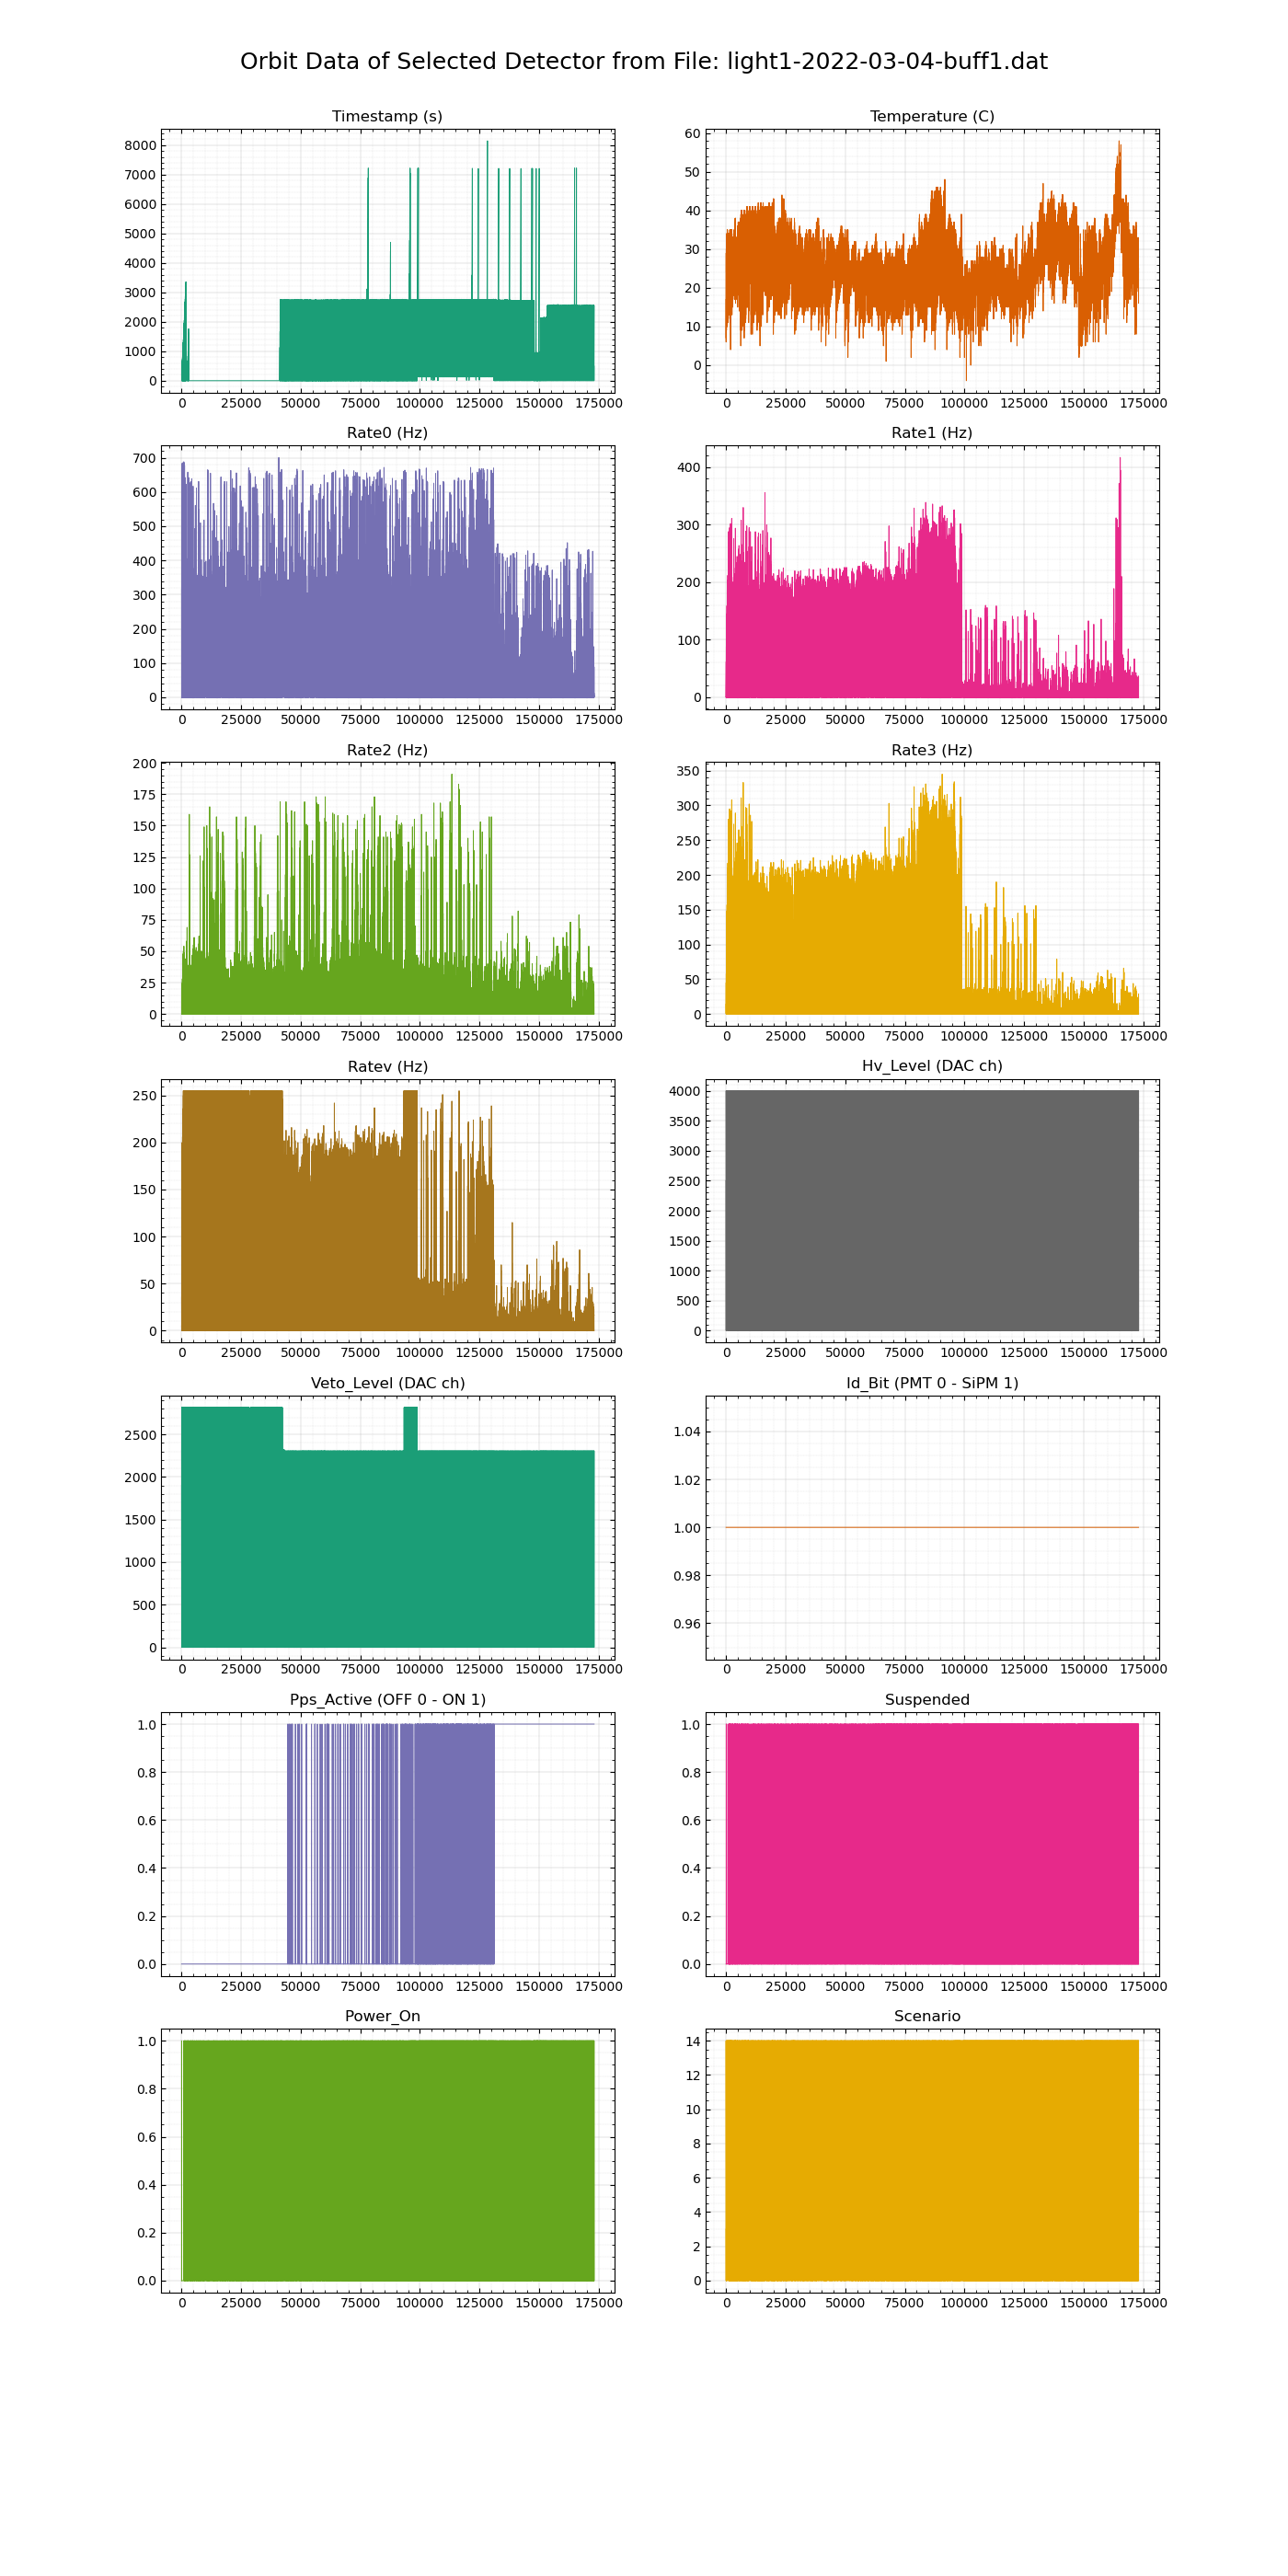

In [3]:
# Now print the Data
fig, axes  = rp.plot_buffer(full_data,title = 'Orbit Data of Selected Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

# Number of Restarts

In [4]:
# Count the number of restarts
restarts = np.unique(full_data['power_on'],return_counts=True)[1][1]
print(rp.bcolors.OKBLUE+'Number of restarts: '+rp.bcolors.OKGREEN+rp.bcolors.BOLD+str(restarts)+rp.bcolors.ENDC)

Number of restarts: 1871


# Complete Mission Temperature

In [5]:
# Get the full data from both
complete_data   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT)

# Get PMT Data
idx_p     = np.where(complete_data['id_bit'] == PMT_ID)[0]
pmt_data  = dict(zip(rp.ORBIT_STRUCT.keys(),[np.array(arr)[idx_p] for arr in complete_data.values()]))

# Get SiPM Data
idx_s     = np.where(complete_data['id_bit'] == SIPM_ID)[0]
sipm_data = dict(zip(rp.ORBIT_STRUCT.keys(),[np.array(arr)[idx_s] for arr in complete_data.values()]))

Line:   0%|          | 0/349101 [00:00<?, ?it/s]

(19055.0, 19372.0)

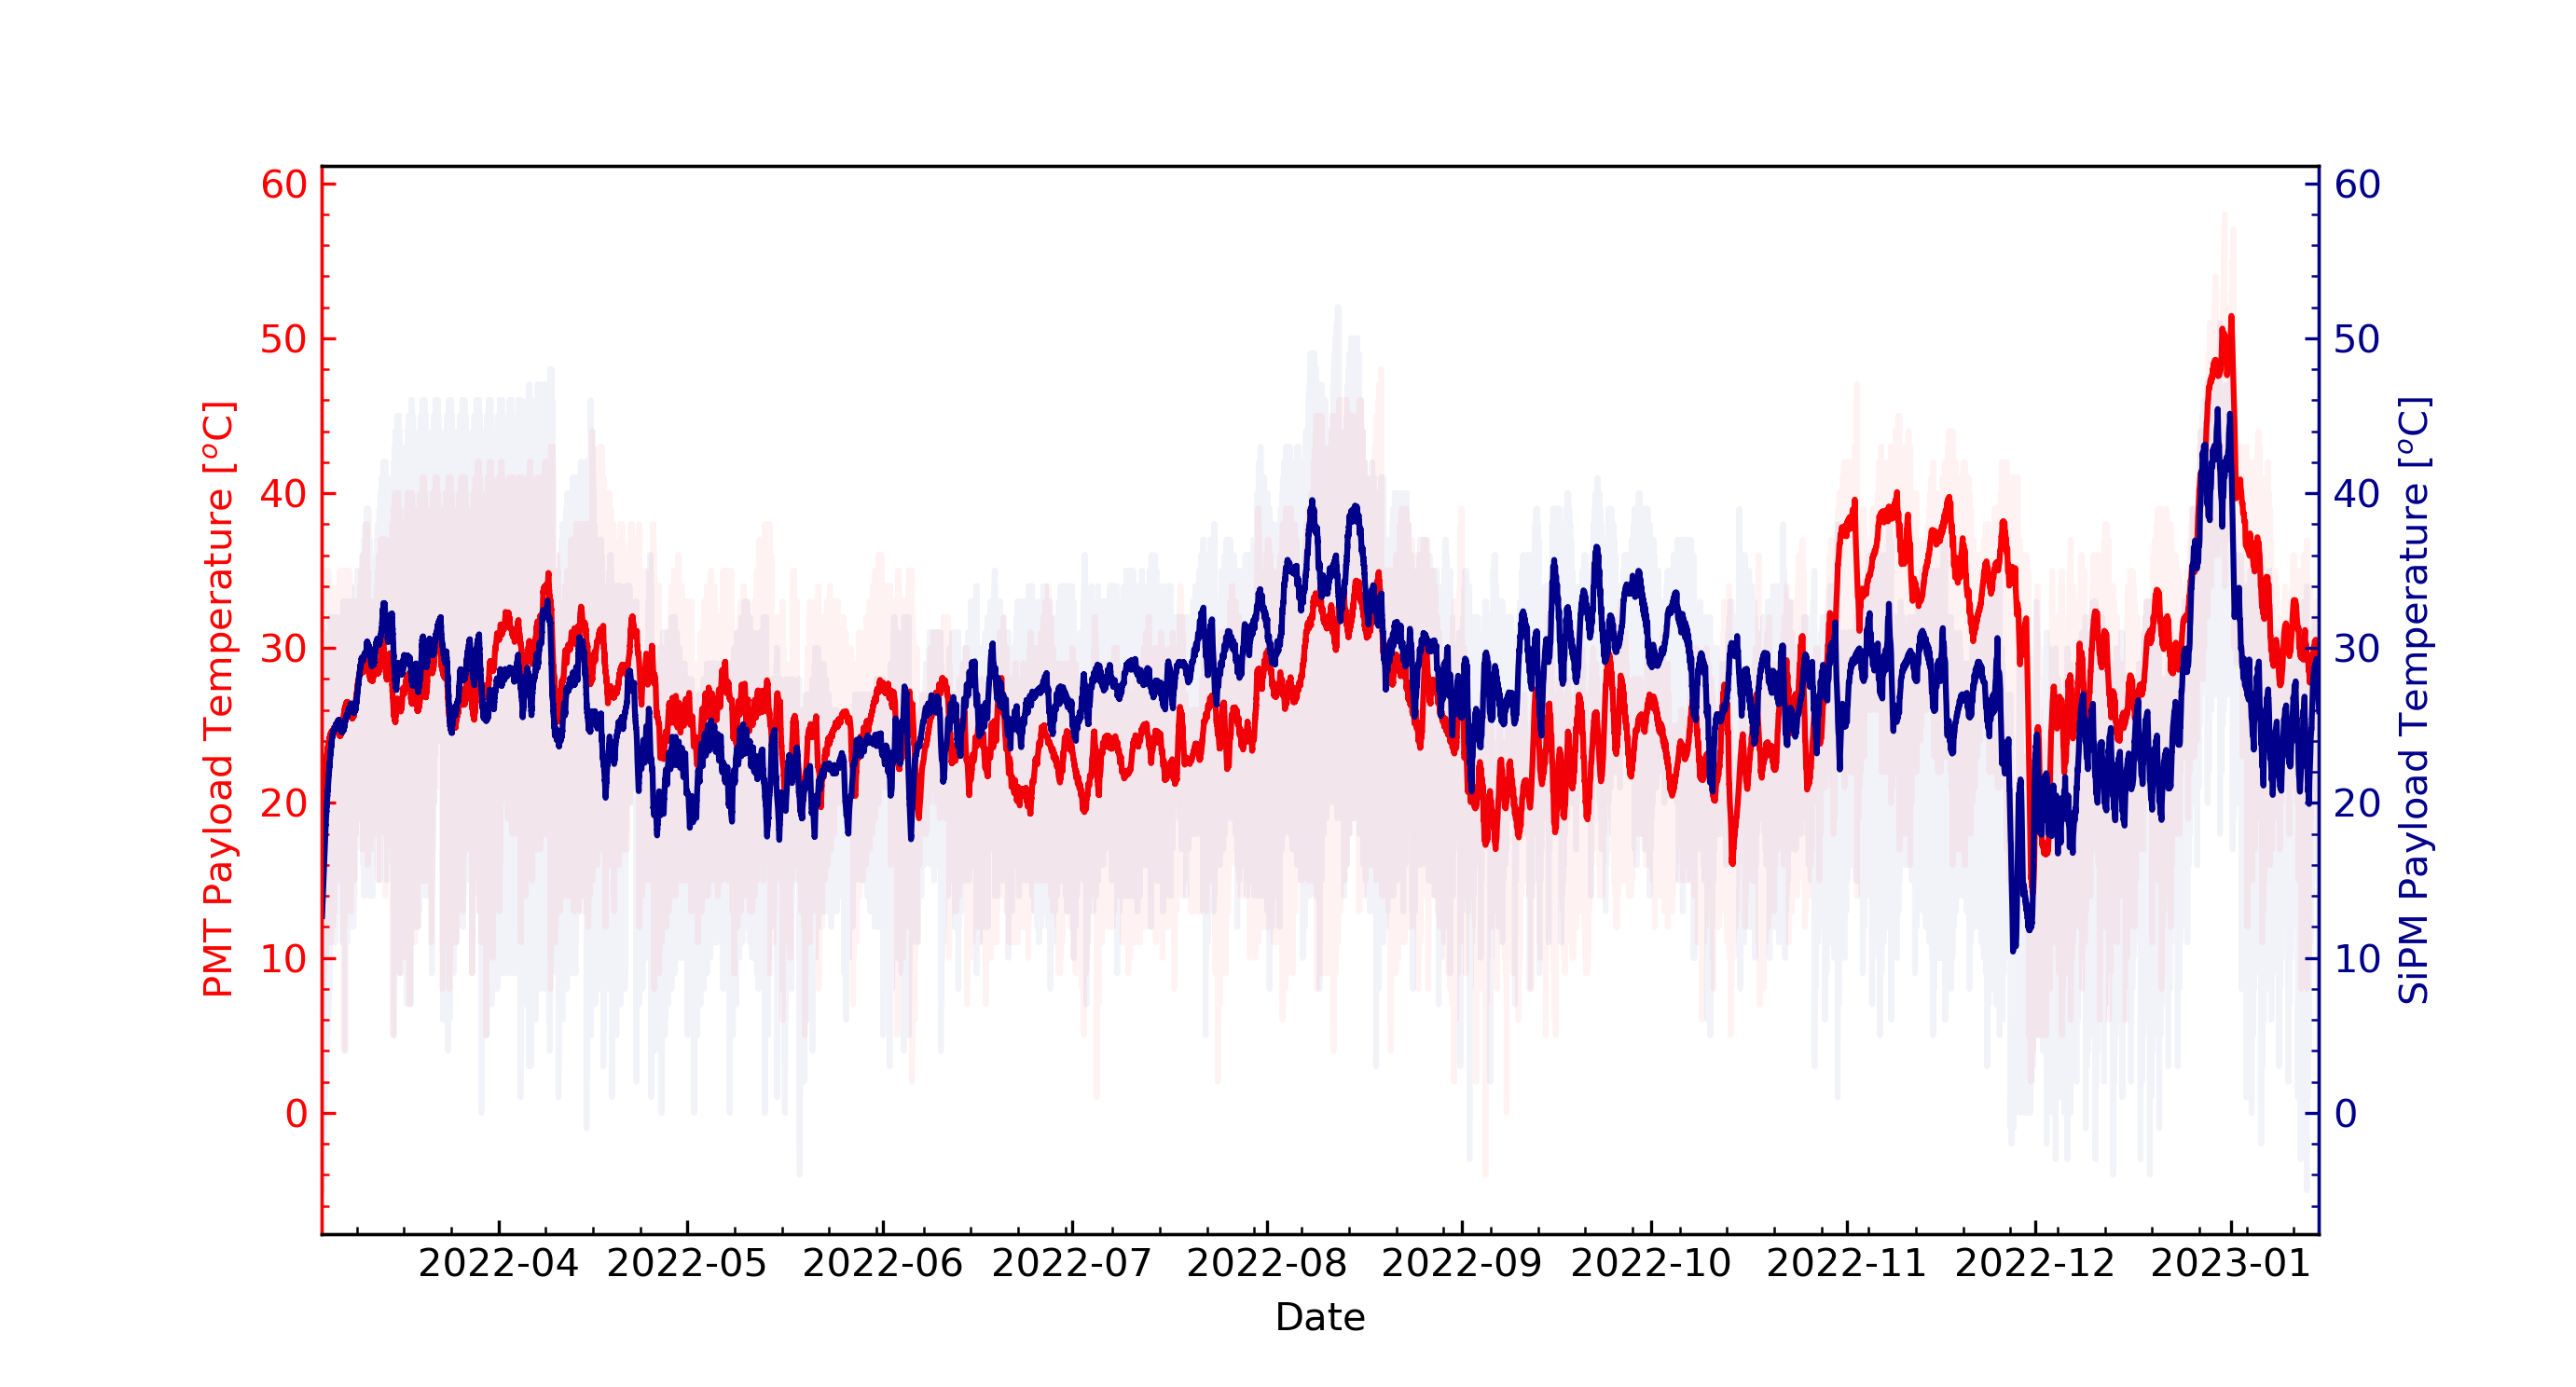

In [6]:
# Create the temperature plot

# Create the figure
CMTOIN = 0.393701*1.8
fig     = plt.figure(figsize=(13*CMTOIN,7*CMTOIN),dpi=300)
fig.tight_layout(pad=3)
ax0     = fig.add_subplot(111)
ax1     = ax0.twinx()
color   = ['red','darkblue']

# Get the date Range
dates = pd.date_range(start="2022-03-04",end="2023-01-15",periods=len(pmt_data['temperature']))

# Plot the temperature
ax0.plot(dates, pmt_data['temperature'],c=color[0],alpha=0.05)
ax0.plot(dates, savgol_filter(pmt_data['temperature'],401,1),c=color[0])

# Get the date Range
dates = pd.date_range(start="2022-03-04",end="2023-01-15",periods=len(sipm_data['temperature']))

# Plot pressure
ax1.plot(dates, sipm_data['temperature'],c=color[1],alpha=0.05)
ax1.plot(dates, savgol_filter(sipm_data['temperature'],401,1),c=color[1])

# Prettify
# ax0.set_xlim(0,max(new_time[idx]))
ax1.spines['left'].set_color(color[0])
ax1.spines['right'].set_color(color[1])
ax1.tick_params(axis ='y', labelcolor = color[1],color=color[1],direction='in')
ax0.tick_params(axis ='y', labelcolor = color[0],color=color[0],direction='in')
ax1.tick_params(axis ='y', labelcolor = color[1],color=color[1],direction='in',which='minor')
ax0.tick_params(axis ='y', labelcolor = color[0],color=color[0],direction='in',which='minor')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.tick_params(axis ='x', direction='in',which='both')
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.set_ylabel(r'PMT Payload Temperature [$^o$C]', color = color[0])
ax1.set_ylabel(r'SiPM Payload Temperature [$^o$C]', color = color[1])
ax0.set_xlabel('Date')
# fig.suptitle('\nTemperature of payloads\nOver Mission Lifetime');
M = np.max([ax0.get_ylim(),ax1.get_ylim()])
m = np.min([ax0.get_ylim(),ax1.get_ylim()])
ax0.set_ylim(m,M)
ax1.set_ylim(m,M)
ax0.set_xlim(min(dates),max(dates))

In [7]:
# fig.savefig("paylod-lifetime-temp.pdf", format="pdf", bbox_inches="tight")

# Apogee Perigee Plot

In [133]:
# Load LIGHT-1 data
data = pd.read_csv('Apogee-Perigee.csv').to_numpy().T

time    = [rp.Time.strptime(d,'%Y-%m-%d %H:%M:%S').to_datetime() for d in data[0]]
apogee  = np.array(data[1],dtype=float)
perigee = np.array(data[2],dtype=float)

# ISS DATA
data_i  = pd.read_csv('ISS.csv').to_numpy().T

time_i  = np.array([rp.Time.strptime(d,'%Y-%m-%d %H:%M:%S').to_datetime()for d in data_i[0]],dtype=np.datetime64)
time_np = np.array([rp.Time(d).to_value('unix') for d in time_i])
start_i = rp.Time.strptime('2021-12-21 00:00:00','%Y-%m-%d %H:%M:%S').to_value('unix')
end_i   = rp.Time(time[0]).to_value('unix') #rp.Time.strptime('2022-02-','%Y-%m-%d %H:%M:%S').to_value('unix')
idx_t   = np.where((start_i <= time_np) & (end_i >= time_np))
time_i  = time_i[idx_t]
height  = np.array(data_i[1][idx_t],dtype=float)

Text(0.5, 0, 'Date')

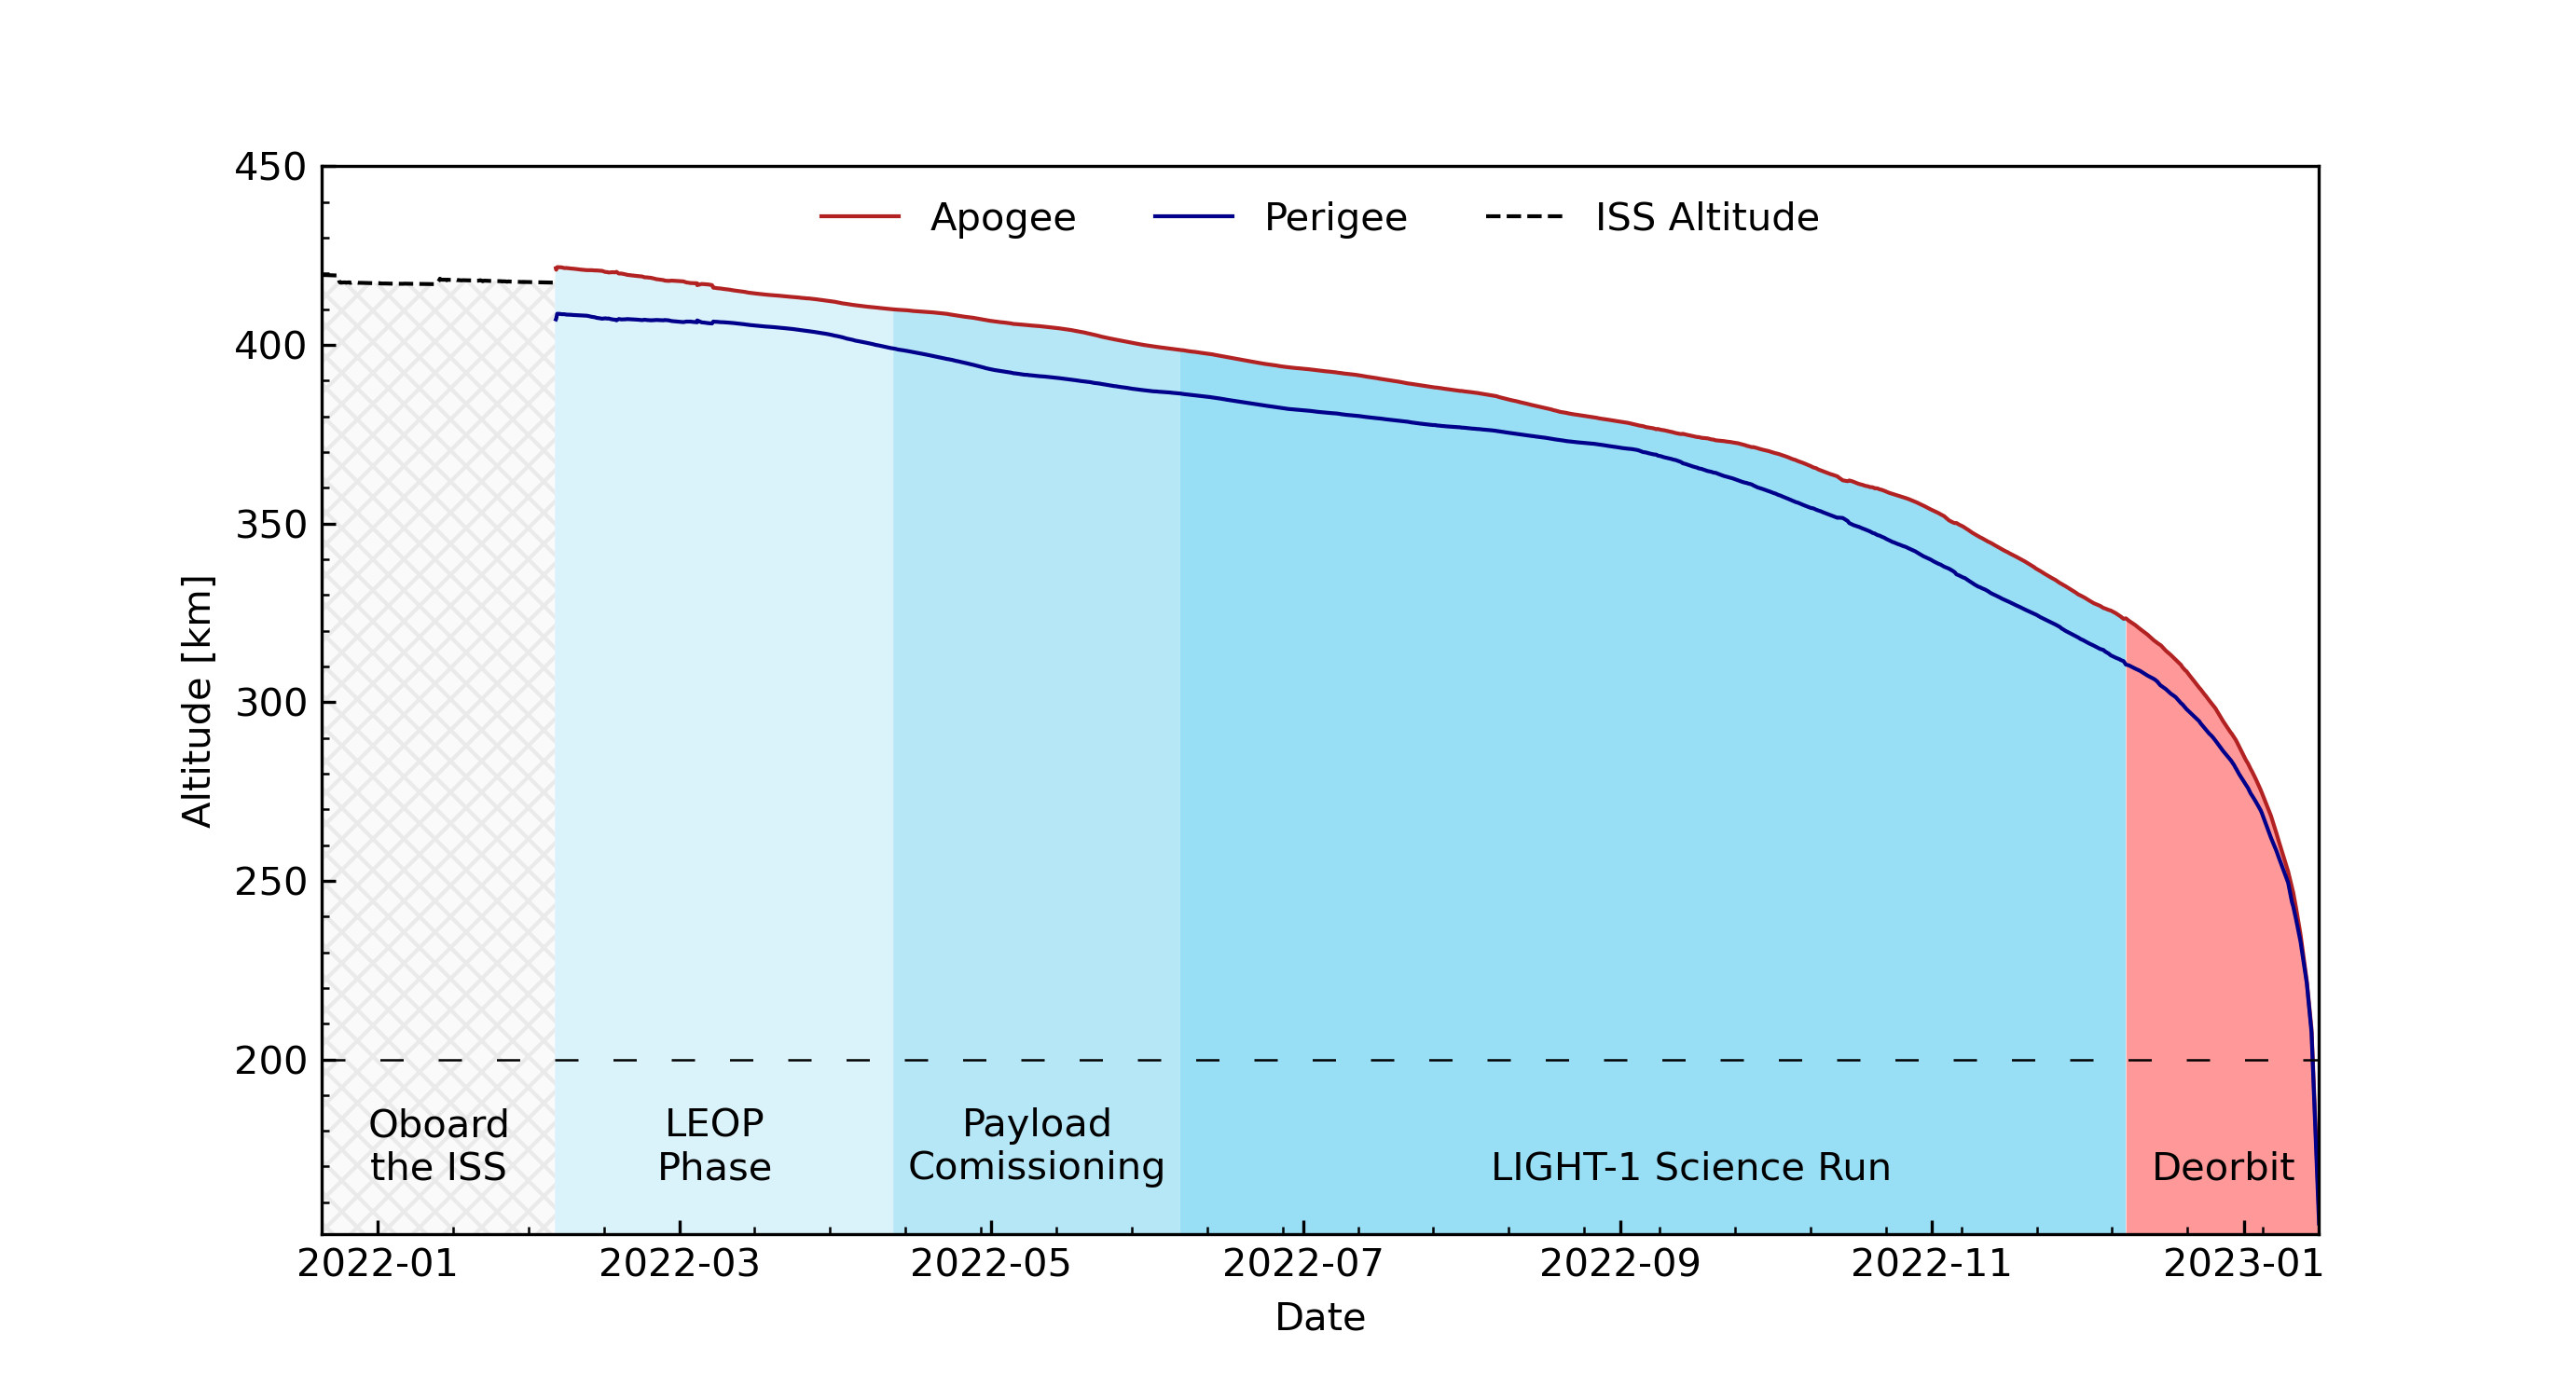

In [257]:
# Make a plot
# Create the Amplitude plot

# Create the figure
CMTOIN = 0.393701*1.8
fig     = plt.figure(figsize=(13*CMTOIN,7*CMTOIN),dpi=300)
fig.tight_layout(pad=3)
ax0     = fig.add_subplot(111)

# Plot the highlighted regions
ax0.fill_between(time_i,height,alpha=1,color='#fafafa',lw=0,hatch="XXX",edgecolor='#eaeaea')
ax0.fill_between(np.append([time_i[-1]],time[0:151]),np.append([height[-1]],apogee[0:151]),alpha=1,color='#DAF3FB',lw=0)
ax0.fill_between(time[150:251],apogee[150:251],alpha=1,color='#B6E7F7',lw=0)
ax0.fill_between(time[250:631],apogee[250:631],alpha=1,color='#98DEF5',lw=0)
ax0.fill_between(time[630:],apogee[630:],alpha=1,color='#ff9999',lw=0)

# Plot LIGHT-1 Positions
ax0.plot(time, apogee,c='firebrick',lw=1,label='Apogee')
ax0.plot(time, perigee,c='darkblue',lw=1,label='Perigee')

# Plot ISS Positions
ax0.plot(time_i,height,c='k',lw=1,ls="--",label="ISS Altitude")

# Add the texts
ax0.text(np.datetime64('2022-01-13'),164,'Oboard\nthe ISS',ha='center',va='bottom')
ax0.text(np.datetime64('2022-03-08'),164,'LEOP\nPhase',ha='center',va='bottom')
ax0.text(np.datetime64('2022-05-10'),164,'Payload\nComissioning',ha='center',va='bottom')
ax0.text(np.datetime64('2022-09-15'),164,'LIGHT-1 Science Run',ha='center',va='bottom')
ax0.text(np.datetime64('2022-12-28'),164,'Deorbit',ha='center',va='bottom')

# Add leader lines
ax0.axhline(200,lw=0.6,ls=(0, (10, 15)),color='k')

# Prettify
ax0.set_ylim(151,450)
ax0.set_xlim(time_i[0],time[-1])
ax0.legend(frameon=False,loc='upper center',ncol=3)
ax0.tick_params(axis = 'both', which = 'both', direction='in')
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.set_ylabel('Altitude [km]')
ax0.set_xlabel('Date')

In [258]:
# fig.savefig("paylod-lifetime.pdf", format="pdf", bbox_inches="tight")